In [1]:
# https://www.kaggle.com/ludobenistant/hr-analytics

In [2]:
import itertools as it
import operator as op
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [3]:
df = pd.read_csv("../data/HR.csv")

In [4]:
df.rename(columns = {
    "average_montly_hours": "avg_monthly_hours",
    "Work_accident": "work_accident",
    "sales": "department"
}, inplace = True)
df

,satisfaction_level,last_evaluation,number_project,avg_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


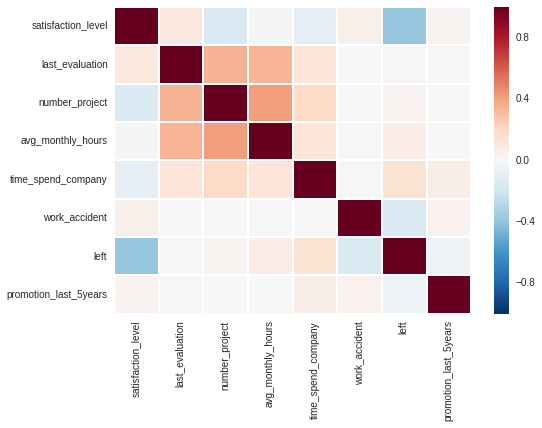

In [5]:
sns.heatmap(df.corr())

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df[["satisfaction_level", "last_evaluation", "number_project", "avg_monthly_hours", "time_spend_company", "work_accident", "promotion_last_5years"]].values,
    df["left"].values, train_size = 0.8, random_state = 1
)

In [7]:
model_poly = make_pipeline(PolynomialFeatures(3), LinearRegression())
model_poly.fit(X_train, y_train)
predictions = model_poly.predict(X_test)
predictions = np.vectorize(lambda x: 0 if x <= 0.5 else 1)(predictions)

In [8]:
print(sum(predictions == y_test), y_test.shape[0])

(2844, 3000)


In [9]:
# ----

In [10]:
import statsmodels.formula.api as smf

In [11]:
formula = "left ~ satisfaction_level + last_evaluation + number_project + avg_monthly_hours + time_spend_company + work_accident==0 + promotion_last_5years==0 + C(salary) + C(department)"
model = smf.logit(formula, data = df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.428358
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   left   No. Observations:                14999
Model:                          Logit   Df Residuals:                    14980
Method:                           MLE   Df Model:                           18
Date:                Tue, 18 Apr 2017   Pseudo R-squ.:                  0.2195
Time:                        15:12:11   Log-Likelihood:                -6424.9
converged:                       True   LL-Null:                       -8232.3
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -4.6170      0.330    -13.994      0.000      -5.264      -3.970
work_accident == 0[T.True]             1.5298      0.090     17.083      0.000       1.354       1.705
promotion_last_5years == 0[T.True]     1.4301      0.258      5.552      0.000       0.925       1.935
C(salary)[T.low]                       1.9441      0.129     15.111      0.000       1.692       2.196
C(salary)[T.medium]                    1.4132      0.129     10.924      0.000       1.160       1.667
C(department)[T.RandD]                -0.4016      0.136     -2.962      0.003      -0.667      -0.136
C(department)[T.accounting]            0.1807      0.122      1.480      0.139      -0.059       0.420
C(department)[T.hr]                    0.4131      0.121      3.415      0.001       0.176       0.650
C(department)[T.management]           -0.2677      0.152     -1.765      0.078      -0.565       0.030
C(department)[T.marketing]             0.1686      0.122      1.386      0.166      -0.070       0.407
C(department)[T.product_mng]           0.0275      0.120      0.230      0.818      -0.207       0.262
C(department)[T.sales]                 0.1419      0.089      1.601      0.109      -0.032       0.316
C(department)[T.support]               0.2307      0.097      2.391      0.017       0.042       0.420
C(department)[T.technical]             0.2509      0.093      2.685      0.007       0.068       0.434
satisfaction_level                    -4.1357      0.098    -42.177      0.000      -4.328      -3.944
last_evaluation                        0.7309      0.149      4.899      0.000       0.439       1.023
number_project                        -0.3151      0.021    -14.775      0.000      -0.357      -0.273
avg_monthly_hours                      0.0045      0.001      8.643      0.000       0.003       0.005
time_spend_company                     0.2678      0.016     17.192      0.000       0.237       0.298
======================================================================================================
"""

In [12]:
model.params.sort_values()
# plot coefficients?
# colormap for blue = neg corr (satisfaction), red = pos corr (low salary), white = no corr (hours/month)?
# also pay attention to p-values

Intercept                            -4.616969
satisfaction_level                   -4.135689
C(department)[T.RandD]               -0.401648
number_project                       -0.315079
C(department)[T.management]          -0.267706
avg_monthly_hours                     0.004460
C(department)[T.product_mng]          0.027465
C(department)[T.sales]                0.141932
C(department)[T.marketing]            0.168630
C(department)[T.accounting]           0.180718
C(department)[T.support]              0.230743
C(department)[T.technical]            0.250864
time_spend_company                    0.267754
C(department)[T.hr]                   0.413096
last_evaluation                       0.730903
C(salary)[T.medium]                   1.413224
promotion_last_5years == 0[T.True]    1.430137
work_accident == 0[T.True]            1.529828
C(salary)[T.low]                      1.944063
dtype: float64

In [13]:
class CompanyModel(object):
    def __init__(self):
        self.results = pd.DataFrame()

    def train(self, data, formula):
        self.model = smf.logit(formula, data = data).fit()

    def predict(self, keys, vals):
        # model.predict returns probability [0.0 - 1.0] that an employee leaves based on the given conditions;
        # we can extend this probability to be the ratio of employees that leave a company with such conditions
        sample = pd.DataFrame([vals], columns = keys)
        sample["attrition"] = self.model.predict(sample)[0]
        self.results = self.results.append(sample, ignore_index = True)

In [14]:
cm = CompanyModel()
cm.train(df, "left ~ satisfaction_level + last_evaluation + number_project + avg_monthly_hours + time_spend_company + work_accident==0 + promotion_last_5years==0 + C(salary) + C(department)")

Optimization terminated successfully.
         Current function value: 0.428358
         Iterations 7


In [15]:
params = {
    "satisfaction_level":    np.arange(0.0, 1.2, 0.2),
    "last_evaluation":       np.arange(0.0, 1.2, 0.2),
    "number_project":        range(2, 10, 2),
    "avg_monthly_hours":     range(100, 350, 50),
    "time_spend_company":    range(2, 14, 4),
    "work_accident":         [0, 1],
    "promotion_last_5years": [0, 1],
    "salary":                ["low", "medium", "high"],
    "department":            ["sales", "technical", "support", "IT", "product_mng", "marketing", "RandD", "accounting", "hr", "management"]
}
# 6 * 6 * 4 * 5 * 3 * 2 * 2 * 3 * 10 = 259200 cases... long runtime
keys, vals = zip(*params.items())
for prod in it.product(*vals):
    cm.predict(keys, prod)

In [16]:
total = len(cm.results)
for quit_rate in [0.01, 0.05, 0.10]:
    l = len(cm.results[cm.results.attrition < quit_rate])
    print("attrition <= {0}%: {1} / {2} condition combinations ({3:.2f}%)".format(100 * quit_rate, l, total, 100.0 * l / total))

attrition <= 1.0%: 55441 / 259200 condition combinations (21.39%)
attrition <= 5.0%: 119669 / 259200 condition combinations (46.17%)
attrition <= 10.0%: 151815 / 259200 condition combinations (58.57%)


In [17]:
# "Designing the Optimal Employee Experience (For Employers' Wallets)"
# see how bad conditions can be for employees before they quit?
# make regression model, figure out how low pay can be (etc.) for each predicted % of employees leaving

In [18]:
cm.results.sort_values("attrition", ascending = False)

,salary,satisfaction_level,last_evaluation,work_accident,promotion_last_5years,number_project,department,avg_monthly_hours,time_spend_company,attrition
12134,low,0.0,1.0,0,0,2,hr,300,10,0.991970
9734,low,0.0,0.8,0,0,2,hr,300,10,0.990718
12029,low,0.0,1.0,0,0,2,technical,300,10,0.990569
12044,low,0.0,1.0,0,0,2,support,300,10,0.990379
12131,low,0.0,1.0,0,0,2,hr,250,10,0.989984
12119,low,0.0,1.0,0,0,2,accounting,300,10,0.989891
12089,low,0.0,1.0,0,0,2,marketing,300,10,0.989769
12014,low,0.0,1.0,0,0,2,sales,300,10,0.989495
7334,low,0.0,0.6,0,0,2,hr,300,10,0.989273
9629,low,0.0,0.8,0,0,2,technical,300,10,0.989101
